# Digital For Industrial Summative - Part 1
 
## Creating A Digital Thread


A Digital Thread is the one unifying theme or characteristic that connects every aspect of an asset or unit, right from its inception and design, to manufacture, deployment, operations, maintenance to eventual retirement.

In analysis, a digital thread is the logical with which we bind and merge the various data sources into one whole, so that it lends itself to quantitative approaches easily.

<img src = 'images/Digital_Thread.JPG' width=500>


A digital thread is a technique to 'stitch' the data that comes in disjoint tables, such that they can be put together logically. That is a task for this exercise.

Data sets provided:

We have been give 5 data sets, all of which related to one month's worth of readings taken at a live volcano site. The volcano was instrumented with multiple sensors in 10 different geographical points (nodes). Our goal is to combine and merge all of this into one digital thread, making it amenable for analysis.

Tasks:

    1.0 Read all the needed input files
    2.0 Plotting Sensor Time Series
    3.0 Descriptive Analysis One data frame at a time 
    4.0 Creating a Digital Thread from the data sets
    5.0 Time Series based analysis
    6.0 Correlations Analysis
    7.0 Data Manipulations to Merge multiple data sets
    8.0 Building A Battery Remaining-Life prediction model

In [594]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import metrics


from sklearn.feature_selection import mutual_info_regression
import os

In [595]:
%matplotlib inline

### 1.0 Read all the needed input files

Create multiple data frames, one to hold each data table.

Convert all Data frame time stamps into date-time format, so that time-based indexing is possible

In [596]:
#creating multiple data frames from data table
datapoints_df=pd.read_csv('datapoints.csv', parse_dates=['timestamp'])
d_df=pd.read_csv('d.csv', parse_dates=['timestamp'])
datatypes_df=pd.read_csv('datatypes.csv')
nodes_df=pd.read_csv('nodes.csv', parse_dates=['created_at', 'updated_at'])
volcanos_df=pd.read_csv('volcanos.csv', parse_dates=['updated_at'])
sensors_df=pd.read_csv('sensors.csv', parse_dates=['created_at', 'updated_at'])

### 2. Plotting Sensor Time Series

Create separate plots for each sensor in the dataset. Show each one in a separate subplot.

**What (if anything) can we tell about the various sensors from the plots?**


In [597]:
datapoint=datapoints_df.copy()

In [598]:
datapoints_df.set_index('timestamp', inplace=True) #setting timestamp column as the new index
#drop irrelevant column for this exercise
datapoints_df=datapoints_df.drop('id',1)# drop column id

In [599]:
datapoints_df.columns

Index(['value', 'sensor_id'], dtype='object')

In [600]:
#datapoints_df.groupby('sensor_id').plot()

In [601]:
#grouping dataframe by sensor id
grouped=datapoints_df.groupby('sensor_id')

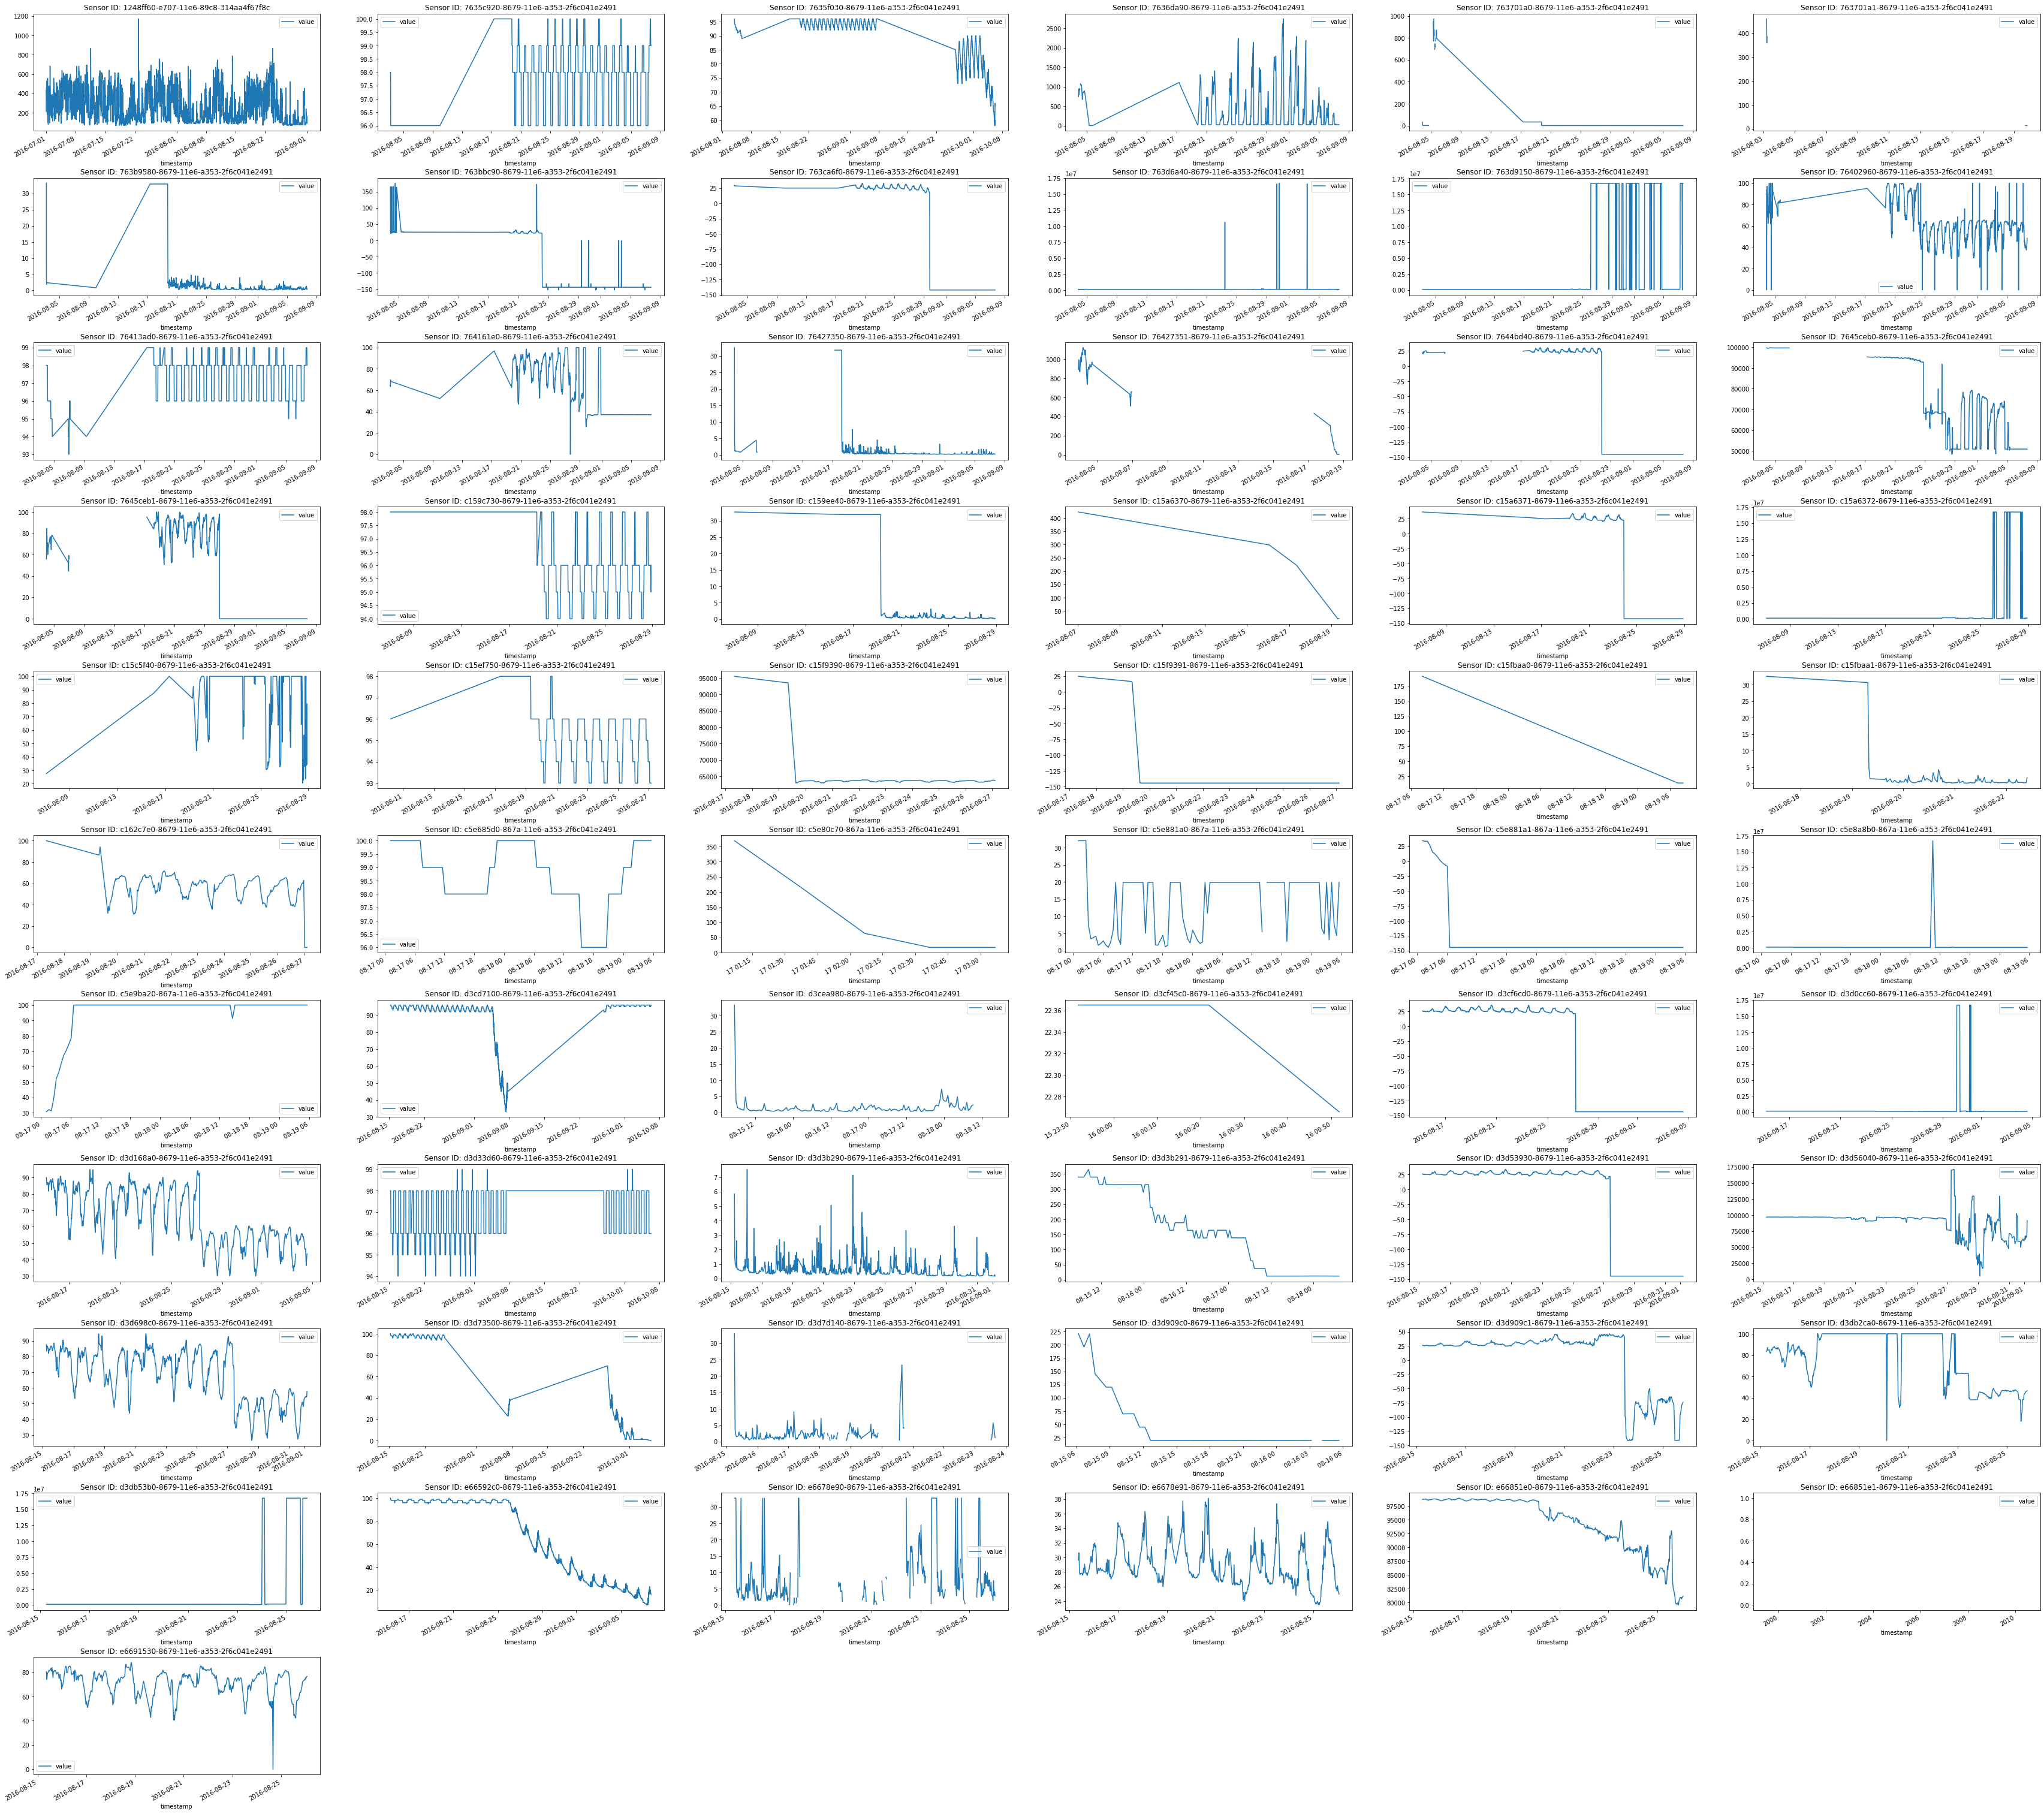

In [602]:
rowlength = round(grouped.ngroups/10)                           # fix up if odd number of groups
fig, axs = plt.subplots(figsize=(60,60), 
                        nrows=11, ncols=rowlength,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

targets = zip(grouped.groups.keys(), axs.flatten())
for key, ax in (targets):
    grouped.get_group(key).plot(ax=ax)
    ax.set_title('Sensor ID: '+str(key))

for i in range( 1,rowlength):
    fig.delaxes(ax= axs[10,i]) #delete unused axes in the subplot array

Observation: 
1. Sensors have varying timestamp intervals (i.e x-axis varies in multiple sensors). This could imply that some sensors where not operational at certain times when others where.
2. Over 50% of sensor readings showed a decline in values towards the end of when the sensor data were captured
3. Sensor ID e66851e1-8679-11e6-a353-2f6c041e2491 did not capture any data
4. Sensor ID 763701a1-8679-11e6-a353-2f6c041e2491 captured data for a brief period then stopped capturing
5. Few number of Sensor ID didnt capture data for some period between their respective time interval of operation

### 3.0 Descriptive Analysis One data frame at a time



You have two data frames: `sensors` and `types` Merge each sensor_id with its type. (Hint: Use `pd.merge()`)



In [603]:
#merging two dataframes
full = pd.merge(sensors_df, datatypes_df, left_on='data_type_id', right_on='id')

In [604]:
#inspecting merged dataframe
full.head(2)

id_x description  data_frequency   status  \
0  c15a6370-8679-11e6-a353-2f6c041e2491          \N         1800000  OFFLINE   
1  7636da90-8679-11e6-a353-2f6c041e2491          \N         1800000  OFFLINE   

                 created_at                       updated_at  \
0 2016-08-07 00:51:40+00:00 2016-09-29 19:41:07.066000+00:00   
1 2016-08-03 21:50:32+00:00 2016-09-30 18:12:04.577000+00:00   

                           data_type_id                               node_id  \
0  35dcdad0-8679-11e6-bda3-ef77801087ee  c147ece0-8679-11e6-a353-2f6c041e2491   
1  35dcdad0-8679-11e6-bda3-ef77801087ee  762c5340-8679-11e6-a353-2f6c041e2491   

                                   id_y                          type si_unit  \
0  35dcdad0-8679-11e6-bda3-ef77801087ee  carbon dioxide concentration     ppm   
1  35dcdad0-8679-11e6-bda3-ef77801087ee  carbon dioxide concentration     ppm   

  type_id  
0  GP_CO2  
1  GP_CO2

3.1 Question: What does this achieve? Why should we do this?

Answer: This gives clarity and proper understanding of the function of each sensor IDs. It is important to do this because it aids detailed analysis, classification and easy reference. Rather than making reference to a cumbersome sensor ID string we can easily reference the sensor type,  type_id, and units


3.2: How many sensors of each type are there?

In [605]:
#Getting the count of sensors for each type
full.type.value_counts()

pressure                          10
carbon dioxide concentration      10
temperature                       10
humidity                          10
hydrogen sulfide concentration    10
battery                           10
RSAM                               1
Name: type, dtype: int64

----

### 4.0 Creating a Digital Thread from the data sets**

**Goal: Merge everything into one wide data table ** 

Take the raw `datapoints` data frame and merge it with all the `sensors` and their types.

In [606]:
#merging dataframes
data = pd.merge(datapoint, full, left_on='sensor_id', right_on='id_x')

-----

In [607]:
#Inspecting dataframe
data.head(5)

id  value                 timestamp  \
0  764c5e60-8679-11e6-a353-2f6c041e2491   98.0 2016-08-03 04:39:25+00:00   
1  765251d0-8679-11e6-a353-2f6c041e2491   98.0 2016-08-03 04:47:41+00:00   
2  7655fb50-8679-11e6-a353-2f6c041e2491   98.0 2016-08-03 05:08:52+00:00   
3  7659cbe0-8679-11e6-a353-2f6c041e2491   98.0 2016-08-03 05:14:08+00:00   
4  765dea90-8679-11e6-a353-2f6c041e2491   96.0 2016-08-03 05:28:55+00:00   

                              sensor_id                                  id_x  \
0  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   
1  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   
2  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   
3  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   
4  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   

  description  data_frequency   status                created_at  \
0          \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
1          \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
2          \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
3          \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
4          \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   

                        updated_at                          data_type_id  \
0 2016-09-29 20:13:52.793000+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   
1 2016-09-29 20:13:52.793000+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   
2 2016-09-29 20:13:52.793000+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   
3 2016-09-29 20:13:52.793000+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   
4 2016-09-29 20:13:52.793000+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   

                                node_id                                  id_y  \
0  762b8ff0-8679-11e6-a353-2f6c041e2491  35dcdad2-8679-11e6-bda3-ef77801087ee   
1  762b8ff0-8679-11e6-a353-2f6c041e2491  35dcdad2-8679-11e6-bda3-ef77801087ee   
2  762b8ff0-8679-11e6-a353-2f6c041e2491  35dcdad2-8679-11e6-bda3-ef77801087ee   
3  762b8ff0-8679-11e6-a353-2f6c041e2491  35dcdad2-8679-11e6-bda3-ef77801087ee   
4  762b8ff0-8679-11e6-a353-2f6c041e2491  35dcdad2-8679-11e6-bda3-ef77801087ee   

      type     si_unit type_id  
0  battery  percentage     BAT  
1  battery  percentage     BAT  
2  battery  percentage     BAT  
3  battery  percentage     BAT  
4  battery  percentage     BAT

### 5.0 Time Series based analysis

Now, we are going to take this stitched data frame and use it for our analysis. Specifically, we are going to perform Time-based analysis on this data.

     Note: If by this point the time stamp is not in datetime format, make sure it is in datetime format.
    Step 1: Resample the dataset to the daily level. (One observation per date)
    Step 2: For the resampled data, calculate the daily mean, min and max values for each sensor id.

Resample to get daily averages.
Then subset to select the columns you need.

Present the data in a summary similar to the example presented below:


![title](example-1.png)

In [608]:
#setting datetime index for our stitched dataframe
data.set_index('timestamp',  inplace=True)

In [609]:
data.head(2)

id  value  \
timestamp                                                                
2016-08-03 04:39:25+00:00  764c5e60-8679-11e6-a353-2f6c041e2491   98.0   
2016-08-03 04:47:41+00:00  765251d0-8679-11e6-a353-2f6c041e2491   98.0   

                                                      sensor_id  \
timestamp                                                         
2016-08-03 04:39:25+00:00  7635c920-8679-11e6-a353-2f6c041e2491   
2016-08-03 04:47:41+00:00  7635c920-8679-11e6-a353-2f6c041e2491   

                                                           id_x description  \
timestamp                                                                     
2016-08-03 04:39:25+00:00  7635c920-8679-11e6-a353-2f6c041e2491          \N   
2016-08-03 04:47:41+00:00  7635c920-8679-11e6-a353-2f6c041e2491          \N   

                           data_frequency   status                created_at  \
timestamp                                                                      
2016-08-03 04:39:25+00:00         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
2016-08-03 04:47:41+00:00         1800000  OFFLINE 2016-08-03 04:39:25+00:00   

                                                updated_at  \
timestamp                                                    
2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
2016-08-03 04:47:41+00:00 2016-09-29 20:13:52.793000+00:00   

                                                   data_type_id  \
timestamp                                                         
2016-08-03 04:39:25+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   
2016-08-03 04:47:41+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee   

                                                        node_id  \
timestamp                                                         
2016-08-03 04:39:25+00:00  762b8ff0-8679-11e6-a353-2f6c041e2491   
2016-08-03 04:47:41+00:00  762b8ff0-8679-11e6-a353-2f6c041e2491   

                                                           id_y     type  \
timestamp                                                                  
2016-08-03 04:39:25+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee  battery   
2016-08-03 04:47:41+00:00  35dcdad2-8679-11e6-bda3-ef77801087ee  battery   

                              si_unit type_id  
timestamp                                      
2016-08-03 04:39:25+00:00  percentage     BAT  
2016-08-03 04:47:41+00:00  percentage     BAT

In [610]:
#Grouping data by sensor_id and type carrying out aggregate function
daily = data.groupby(["sensor_id",'type'])['value'].resample('D').agg([np.mean, min, max])

In [611]:
#check grouped daTA
daily

mean  \
sensor_id                            type     timestamp                               
1248ff60-e707-11e6-89c8-314aa4f67f8c RSAM     2016-07-01 00:00:00+00:00  306.902098   
                                              2016-07-02 00:00:00+00:00  267.804196   
                                              2016-07-03 00:00:00+00:00  286.972028   
                                              2016-07-04 00:00:00+00:00  339.860140   
                                              2016-07-05 00:00:00+00:00  445.828571   
...                                                                             ...   
e6691530-8679-11e6-a353-2f6c041e2491 humidity 2016-09-03 00:00:00+00:00         NaN   
                                              2016-09-04 00:00:00+00:00         NaN   
                                              2016-09-05 00:00:00+00:00         NaN   
                                              2016-09-06 00:00:00+00:00         NaN   
                                              2016-09-07 00:00:00+00:00         NaN   

                                                                           min  \
sensor_id                            type     timestamp                          
1248ff60-e707-11e6-89c8-314aa4f67f8c RSAM     2016-07-01 00:00:00+00:00   81.0   
                                              2016-07-02 00:00:00+00:00  113.0   
                                              2016-07-03 00:00:00+00:00  109.0   
                                              2016-07-04 00:00:00+00:00   89.0   
                                              2016-07-05 00:00:00+00:00  124.0   
...                                                                        ...   
e6691530-8679-11e6-a353-2f6c041e2491 humidity 2016-09-03 00:00:00+00:00    NaN   
                                              2016-09-04 00:00:00+00:00    NaN   
                                              2016-09-05 00:00:00+00:00    NaN   
                                              2016-09-06 00:00:00+00:00    NaN   
                                              2016-09-07 00:00:00+00:00    NaN   

                                                                           max  
sensor_id                            type     timestamp                         
1248ff60-e707-11e6-89c8-314aa4f67f8c RSAM     2016-07-01 00:00:00+00:00  683.0  
                                              2016-07-02 00:00:00+00:00  558.0  
                                              2016-07-03 00:00:00+00:00  513.0  
                                              2016-07-04 00:00:00+00:00  637.0  
                                              2016-07-05 00:00:00+00:00  612.0  
...                                                                        ...  
e6691530-8679-11e6-a353-2f6c041e2491 humidity 2016-09-03 00:00:00+00:00    NaN  
                                              2016-09-04 00:00:00+00:00    NaN  
                                              2016-09-05 00:00:00+00:00    NaN  
                                              2016-09-06 00:00:00+00:00    NaN  
                                              2016-09-07 00:00:00+00:00    NaN  

[2234 rows x 3 columns]

### 6.0 Correlations Analysis

The next task is to perform a correlation analysis. 

1.  Goal: We want to find all the sensors that are strongly correlated to each other.
2. One of the reasons for doing this is that if two (or more) sensors are very highly correlated, we only need to keep one out of each correlated set. (This reduces the problem size and also takes care of colinearlity-related unstability in certain calculations.)

The Correlation heatmap that we are looking for should be along the following lines:


<img src = "images/example-2.png" width=450 height=200>

First, look for correlations visually. 

**Subtask: Plot all the sensors values (of one type) over time.**

Sub task: Identify all the temperature sensors in the data set. Hint: These are the ones that have the string 'TCA' in their type id's

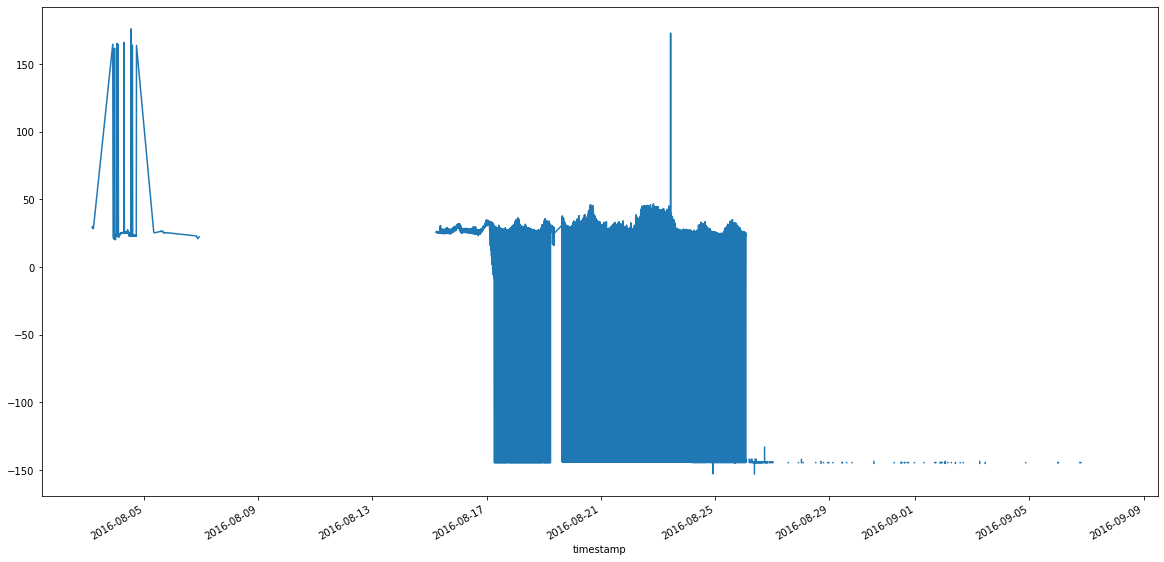

In [612]:
criteria = data.type_id == 'TCA'
plt.figure(figsize=(20,10))
data[criteria]['value'].plot()

In [613]:
#resetting datafrae index
data.reset_index(inplace=True)

In [614]:
s2 = full
temp_sensors = [s for s in s2[s2.type_id =='TCA']['id_x']]
# temperature_sensors = [s for t,s in zip(s2['type_id'], s2['id_x']) if t=='TCA'] # alternative way

In [615]:
#Printing list of temperature sensors
temp_sensors

['763ca6f0-8679-11e6-a353-2f6c041e2491',
 'c15a6371-8679-11e6-a353-2f6c041e2491',
 '7644bd40-8679-11e6-a353-2f6c041e2491',
 'c15f9391-8679-11e6-a353-2f6c041e2491',
 '763bbc90-8679-11e6-a353-2f6c041e2491',
 'd3cf6cd0-8679-11e6-a353-2f6c041e2491',
 'd3d909c1-8679-11e6-a353-2f6c041e2491',
 'd3d53930-8679-11e6-a353-2f6c041e2491',
 'c5e881a1-867a-11e6-a353-2f6c041e2491',
 'e6678e91-8679-11e6-a353-2f6c041e2491']

**Observation:** There are 10 kinds of temperature sensors

** Using Pandas to plot all the temperature sensors on one single plot. **

- Use pandas to loop over each temperature sensor, and plot them one at a time.
- Hint: Group by sensor_ids and hence plot each group per time.

**Task: Creating Subplots - Each temperature sensor gets its own panel**

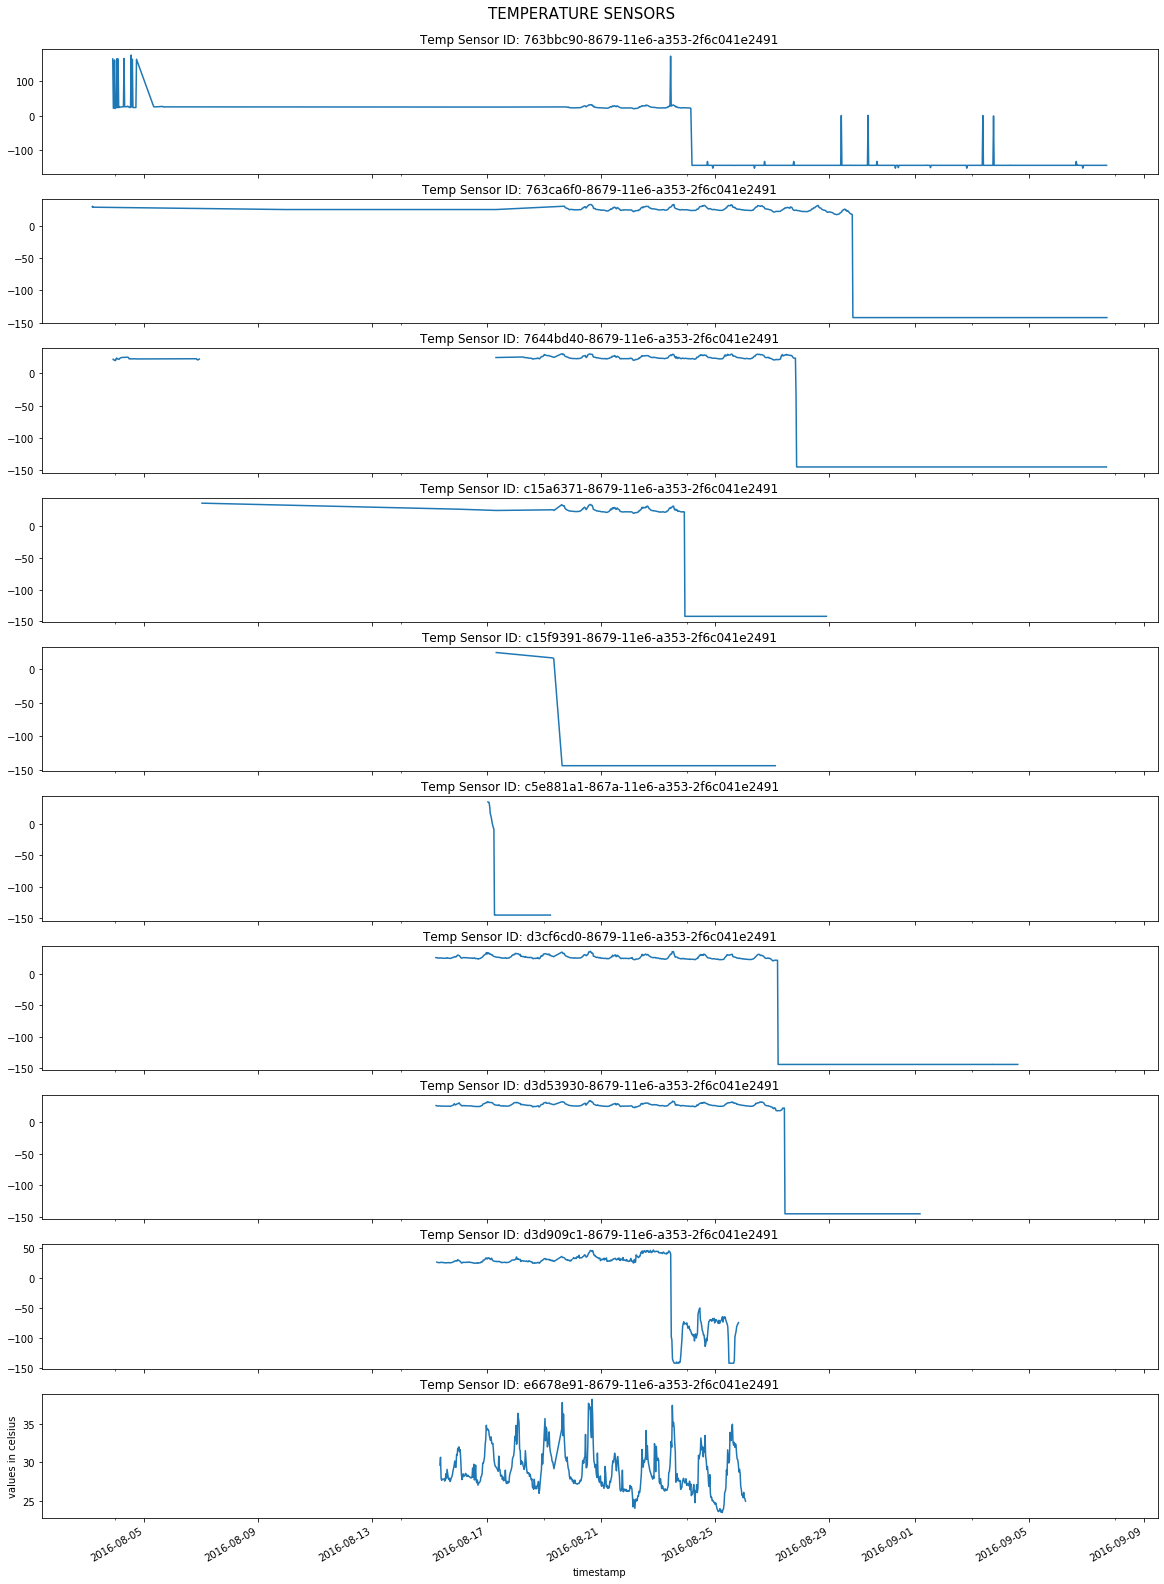

In [616]:
##### temp=data[data.type_id =='TCA']
temp_groups=temp.groupby('sensor_id') #grouping by sensor_id
fig, axs = plt.subplots(10, sharex=True)
fig.set_size_inches(20,30)


for index, group in enumerate(temp_groups):
    
    #plt.figure(figsize=(20, 8))
    sensor_id, sensor_df = group
    sensor_df.set_index('timestamp', inplace=True)
    sensor_df.value.plot(ax=axs[index])
    #plt.format_xdata=mdates.DateFormatter('%Y-%m-%d')
    axs[index].set_title('Temp Sensor ID: '+str(sensor_id))
    plt.ylabel('values in celsius')
    
fig.suptitle('TEMPERATURE SENSORS', size=15, y=0.9);

Question: Based on the plots being made, comment on the readings made by the temperature sensors.

Looking closely at the panels. The following observations where made:
    1. A large proportion of  positive values fall between the 25-50 range (with an estimaed mean of around 25 through visual inspection). However some supposed outlier readings can be detected in the first sensor
    2. There seems to be errors in the readings because we are seeing readings giving negative values of around -150. This is questionable due to the fact the it is a volcanic site. It is expected to be hot not cold
    3. My first major assumption will be that the intended readings for the errors can be accepted by removing the negative signs. This is due to the 0bserved trend in all temperature panels as they lie around - 150. Perhaps the intended temperature is 150 and  there was error in data collection
    4. 6 out of the 10 temperature sensors started recording readings much later in operation

**Task: Clean Up Sensor Data**

In [617]:
#creating a copy of temperature sensors dataframe
temp_df=temp.copy()

## Task: Creating a reshaped Data Frame of Temperature sensors

For this, we are going to have each column be 1 sensor... from 1 to 10. The rows will be timestamps, as before.

Hint: pd.pivot() is perfect for this task.

In [618]:
# df.pivot(index='patient', columns='obs', values='score')

Since this is a real sensor data set, there are some time stamps and sensor_id's that are repeating. (Unfortunately, this happens often in real data sets.)

**Task: Find all rows with the same [Timestamp, Sensor_id] and delete them **

**Here's a clever way to find out all the duplicated rows.**

Some Timestamp and sensor_id are repeating. That causes Indexing problems.

In [619]:
#pd.concat(g for _, g in df.groupby("ID") if len(g) > 1)

**Task: Drop Duplicates**
1. Drop all the rows where timestamp and sensor_id are duplicated
2. Pivot the table
3. Resample the temperature data to daily level.
4. Calculate the mean of the resampled daily data.

In [620]:
#dropping duplicates
tdf = temp_df.drop_duplicates(subset = ['timestamp', 'sensor_id'], keep='first')

In [621]:
#temp_df_cor = tdf.pivot(index='timestamp', columns='sensor_id', values='value')
pivoted = tdf.pivot(index='timestamp', columns='sensor_id', values='value')

In [622]:
daily_temp_cor_df = pivoted.resample('D').mean()

In [623]:
#confirming the number of temperature sensors
daily_temp_cor_df.shape

(65, 10)

In [624]:
#checking dataframe
daily_temp_cor_df.head(2)

sensor_id                  763bbc90-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                             78.082000   
2016-08-04 00:00:00+00:00                             48.245556   

sensor_id                  763ca6f0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                28.865   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  7644bd40-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                             21.067500   
2016-08-04 00:00:00+00:00                             23.583611   

sensor_id                  c15a6371-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  c15f9391-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  c5e881a1-867a-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  d3cf6cd0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  d3d53930-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  d3d909c1-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-08-03 00:00:00+00:00                                   NaN   
2016-08-04 00:00:00+00:00                                   NaN   

sensor_id                  e6678e91-8679-11e6-a353-2f6c041e2491  
timestamp                                                        
2016-08-03 00:00:00+00:00                                   NaN  
2016-08-04 00:00:00+00:00                                   NaN

Now, we are finally ready to calculate the correlations across sensor values. Hint: `Use corr()`

In [625]:
#correlation analysis
corr_df = daily_temp_cor_df.corr()

In [626]:
# # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# # top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

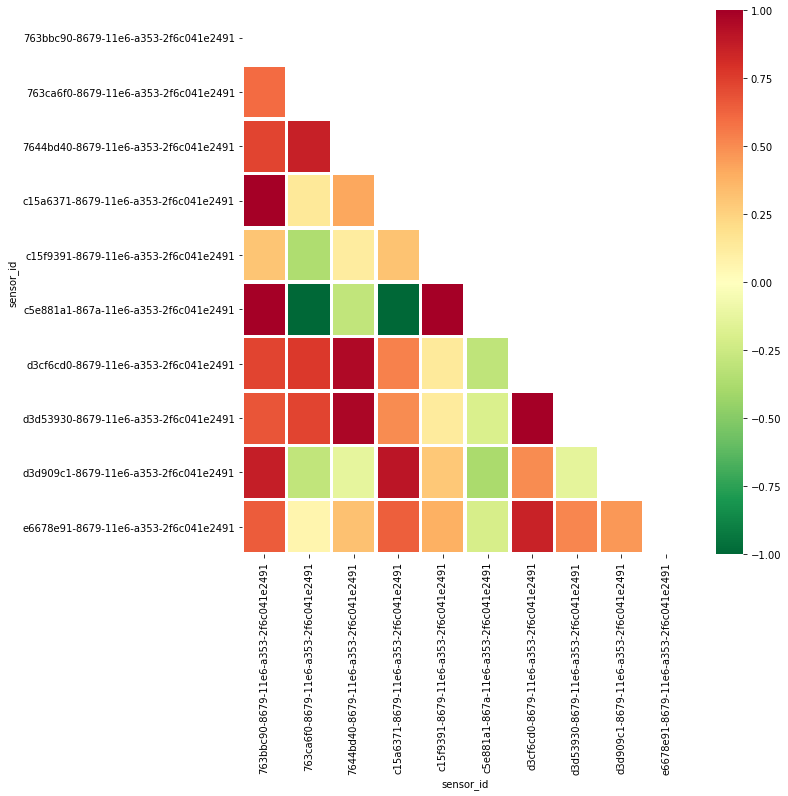

In [627]:
# # Create the heatmap using seaborn library. 
# # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, ax=ax)
 
# # Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [628]:
# full2 = full.reset_index().drop_duplicates(subset = ['timestamp', 'sensor_id'], keep='first')
full2 = data.reset_index().drop_duplicates(subset = ['timestamp', 'sensor_id'], keep='first')

In [629]:
full_wide = full2.pivot(index='timestamp', columns='sensor_id', values='value')

In [630]:
daily_all_sensors = full_wide.resample('D').mean()

In [631]:
#inspecting dataframe
daily_all_sensors.head(2)

sensor_id                  1248ff60-e707-11e6-89c8-314aa4f67f8c  \
timestamp                                                         
2016-07-01 00:00:00+00:00                            306.902098   
2016-07-02 00:00:00+00:00                            267.804196   

sensor_id                  7635c920-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  7635f030-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  7636da90-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763701a0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763701a1-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763b9580-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763bbc90-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763ca6f0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  763d6a40-8679-11e6-a353-2f6c041e2491  ...  \
timestamp                                                        ...   
2016-07-01 00:00:00+00:00                                   NaN  ...   
2016-07-02 00:00:00+00:00                                   NaN  ...   

sensor_id                  d3d909c0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  d3d909c1-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  d3db2ca0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  d3db53b0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00:00:00+00:00                                   NaN   

sensor_id                  e66592c0-8679-11e6-a353-2f6c041e2491  \
timestamp                                                         
2016-07-01 00:00:00+00:00                                   NaN   
2016-07-02 00

**Question:**
Based on the results of the correlation heatmap for temperature sensors, would you recommend working with all temperature sensors or just a subset?

Answer: I would reccommend working with a subset because some sensors are highly correlated. Using them generally will improve my model. 
Also, Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

**Task: Based on the answer above, remove unnecessary temperature sensors from the data**

In [632]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [633]:
new_daily_temp_cor_df=correlation(daily_temp_cor_df, 0.9)     #set correlation threshold to 0.9

In [634]:
new_daily_temp_cor_df.shape

(65, 6)

**Observation**: Four temperature sensors have been removed

In [635]:
#correlation analysis
corr_df = new_daily_temp_cor_df.corr()

In [636]:
# # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# # top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

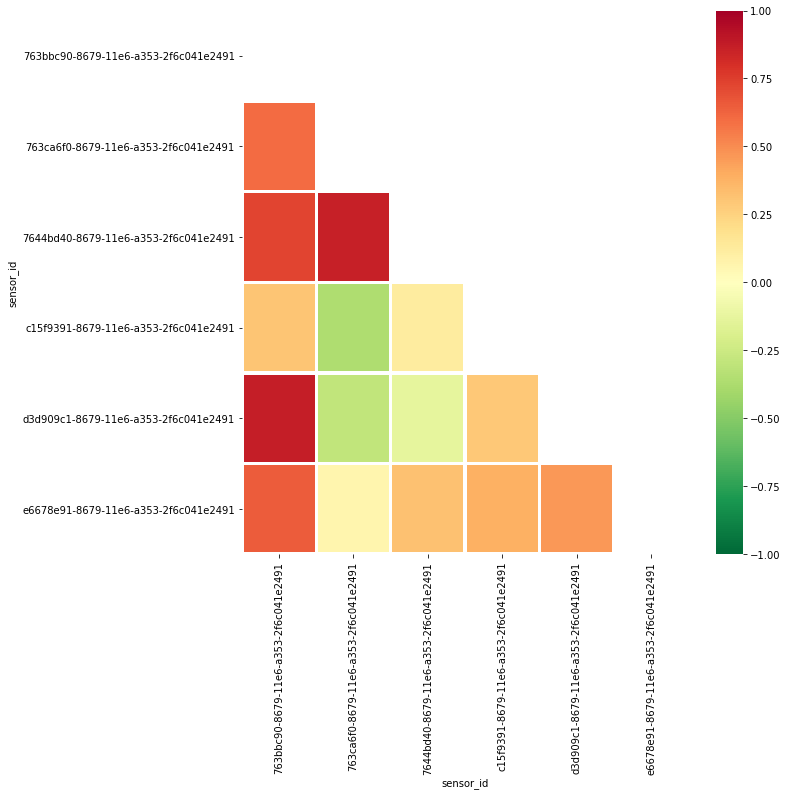

In [637]:
# # Create the heatmap using seaborn library. 
# # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, ax=ax)
 
# # Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

**Optional Task**: 

1. Checking the correlation heatmap for all sensors
1. Removing Highly correlated features in all sensors


In [638]:
corr_df = daily_all_sensors.corr()

In [639]:
# # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# # top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

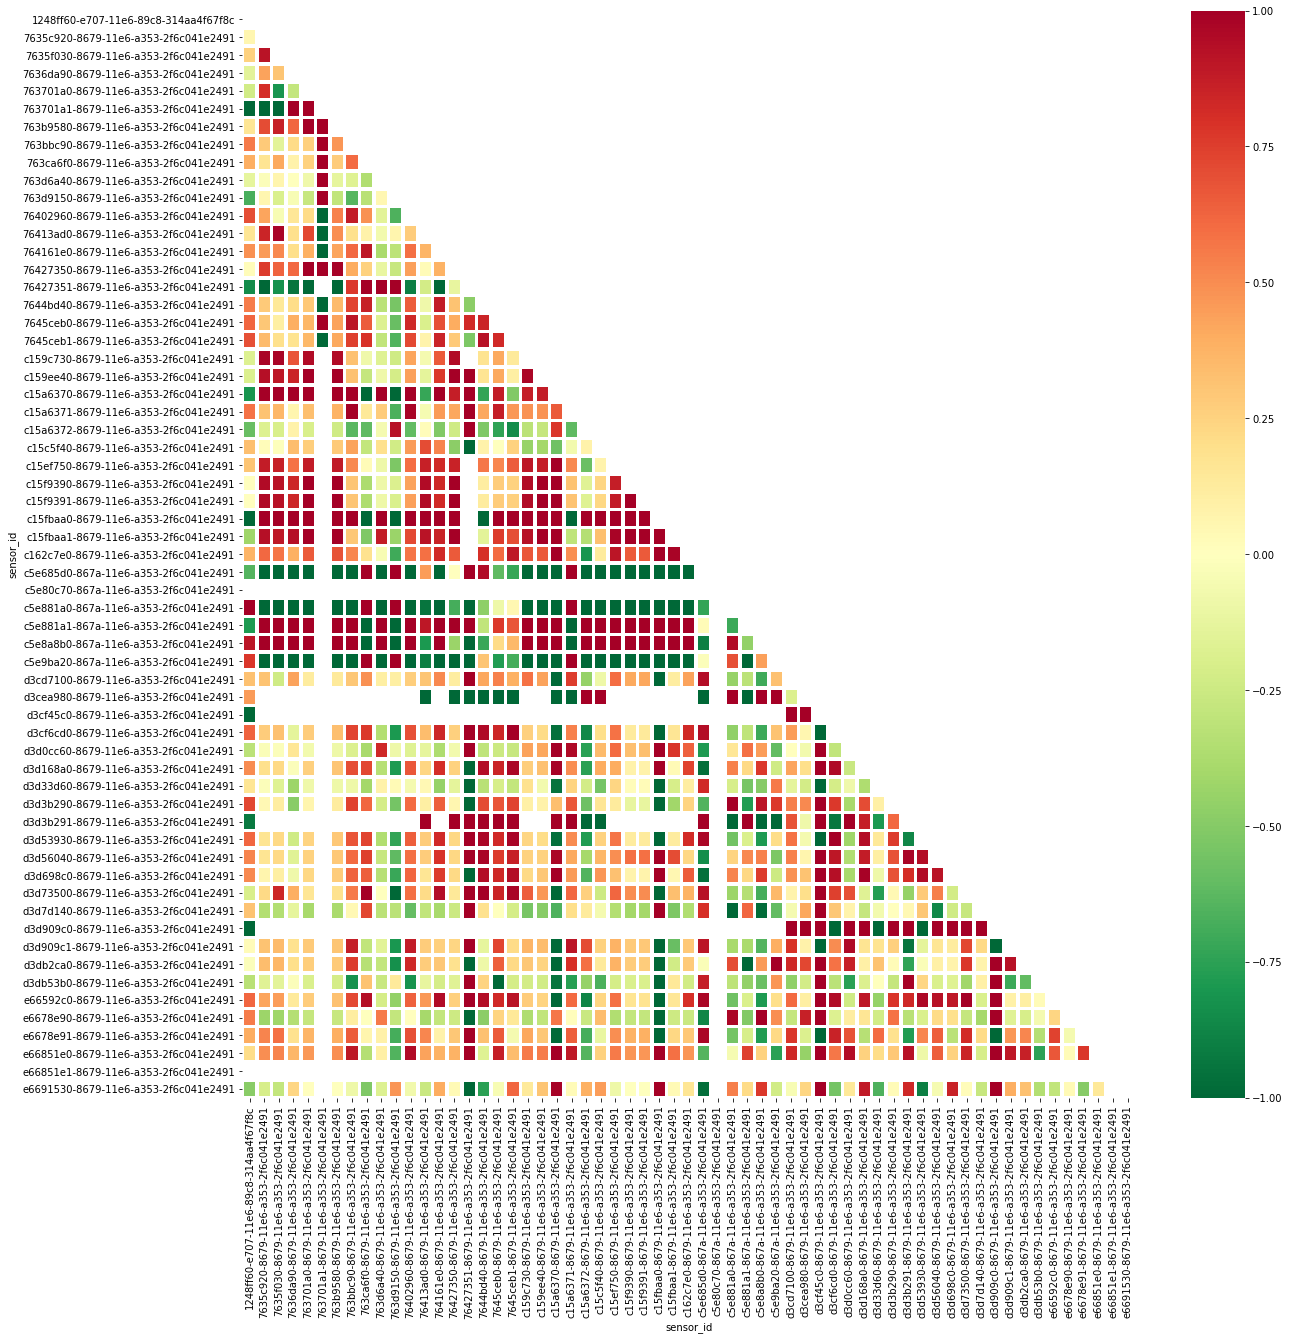

In [640]:
# # Create the heatmap using seaborn library. 
# # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, ax=ax)
 
# # Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

**Observation:** There are a lot of highly correlated features and null featurs. We will remove this and plot heatmap again

In [641]:
df=correlation(corr_df, 0.9)

In [642]:
#checking for missing values
def missing_values_table(df):   #source : https://www.analyticsvidhya.com/blog/2020/06/feature-engineering-guide-data-science-hackathons/
       mis_val = df.isnull().sum()
       mis_val_percent = 100 * df.isnull().sum() / len(df)
       mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
       mis_val_table_ren_columns = mis_val_table.rename(
       columns = {0 : 'Missing Values', 1 : '% of Total Values'})
       mis_val_table_ren_columns = mis_val_table_ren_columns[
           mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
       '% of Total Values', ascending=False).round(1)
       print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"     
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
             " columns that have missing values.")
       return mis_val_table_ren_columns
    
missing_values_table(df) #calling the function

Your selected dataframe has 53 columns.
There are 53 columns that have missing values.


Missing Values  % of Total Values
sensor_id                                                              
e66851e1-8679-11e6-a353-2f6c041e2491              61              100.0
c5e80c70-867a-11e6-a353-2f6c041e2491              61              100.0
763701a1-8679-11e6-a353-2f6c041e2491              43               70.5
d3cf45c0-8679-11e6-a353-2f6c041e2491              37               60.7
d3d3b291-8679-11e6-a353-2f6c041e2491              22               36.1
d3cea980-8679-11e6-a353-2f6c041e2491              22               36.1
76427351-8679-11e6-a353-2f6c041e2491              12               19.7
c162c7e0-8679-11e6-a353-2f6c041e2491               8               13.1
c15fbaa1-8679-11e6-a353-2f6c041e2491               8               13.1
c15fbaa0-8679-11e6-a353-2f6c041e2491               8               13.1
c159ee40-8679-11e6-a353-2f6c041e2491               7               11.5
764161e0-8679-11e6-a353-2f6c041e2491               6                9.8
7635c920-8679-11e6-a353-2f6c041e2491               6                9.8
76402960-8679-11e6-a353-2f6c041e2491               6                9.8
763d9150-8679-11e6-a353-2f6c041e2491               6                9.8
763d6a40-8679-11e6-a353-2f6c041e2491               6                9.8
763ca6f0-8679-11e6-a353-2f6c041e2491               6                9.8
763bbc90-8679-11e6-a353-2f6c041e2491               6                9.8
763b9580-8679-11e6-a353-2f6c041e2491               6                9.8
763701a0-8679-11e6-a353-2f6c041e2491               6                9.8
7636da90-8679-11e6-a353-2f6c041e2491               6                9.8
7635f030-8679-11e6-a353-2f6c041e2491               6                9.8
c5e9ba20-867a-11e6-a353-2f6c041e2491               5                8.2
c5e8a8b0-867a-11e6-a353-2f6c041e2491               5                8.2
c5e881a1-867a-11e6-a353-2f6c041e2491               5                8.2
c5e881a0-867a-11e6-a353-2f6c041e2491               5                8.2
c5e685d0-867a-11e6-a353-2f6c041e2491               5                8.2
c15a6372-8679-11e6-a353-2f6c041e2491               5                8.2
c15c5f40-8679-11e6-a353-2f6c041e2491               5                8.2
c15a6371-8679-11e6-a353-2f6c041e2491               5                8.2
c15a6370-8679-11e6-a353-2f6c041e2491               5                8.2
7645ceb1-8679-11e6-a353-2f6c041e2491               4                6.6
7644bd40-8679-11e6-a353-2f6c041e2491               4                6.6
76427350-8679-11e6-a353-2f6c041e2491               4                6.6
76413ad0-8679-11e6-a353-2f6c041e2491               4                6.6
d3d7d140-8679-11e6-a353-2f6c041e2491               3                4.9
e66851e0-8679-11e6-a353-2f6c041e2491               3                4.9
e6678e91-8679-11e6-a353-2f6c041e2491               3                4.9
e6678e90-8679-11e6-a353-2f6c041e2491               3                4.9
e66592c0-8679-11e6-a353-2f6c041e2491               3                4.9
d3db53b0-8679-11e6-a353-2f6c041e2491               3                4.9
d3db2ca0-8679-11e6-a353-2f6c041e2491               3                4.9
d3d909c1-8679-11e6-a353-2f6c041e2491               3                4.9
e6691530-8679-11e6-a353-2f6c041e2491               3                4.9
d3d73500-8679-11e6-a353-2f6c041e2491               3                4.9
d3d56040-8679-11e6-a353-2f6c041e2491               3                4.9
d3d3b290-8679-11e6-a353-2f6c041e2491               3                4.9
d3d33d60-8679-11e6-a353-2f6c041e2491               3                4.9
d3d168a0-8679-11e6-a353-2f6c041e2491               3                4.9
d3d0cc60-8679-11e6-a353-2f6c041e2491               3                4.9
d3cf6cd0-8679-11e6-a353-2f6c041e2491               3                4.9
d3cd7100-8679-11e6-a353-2f6c041e2491               3                4.9
1248ff60-e707-11e6-89c8-314aa4f67f8c               2                3.3

In [643]:
df=df[df.columns[df.isnull().mean() < 0.75]] #dropping rows with missing values greater than or equal to 75%

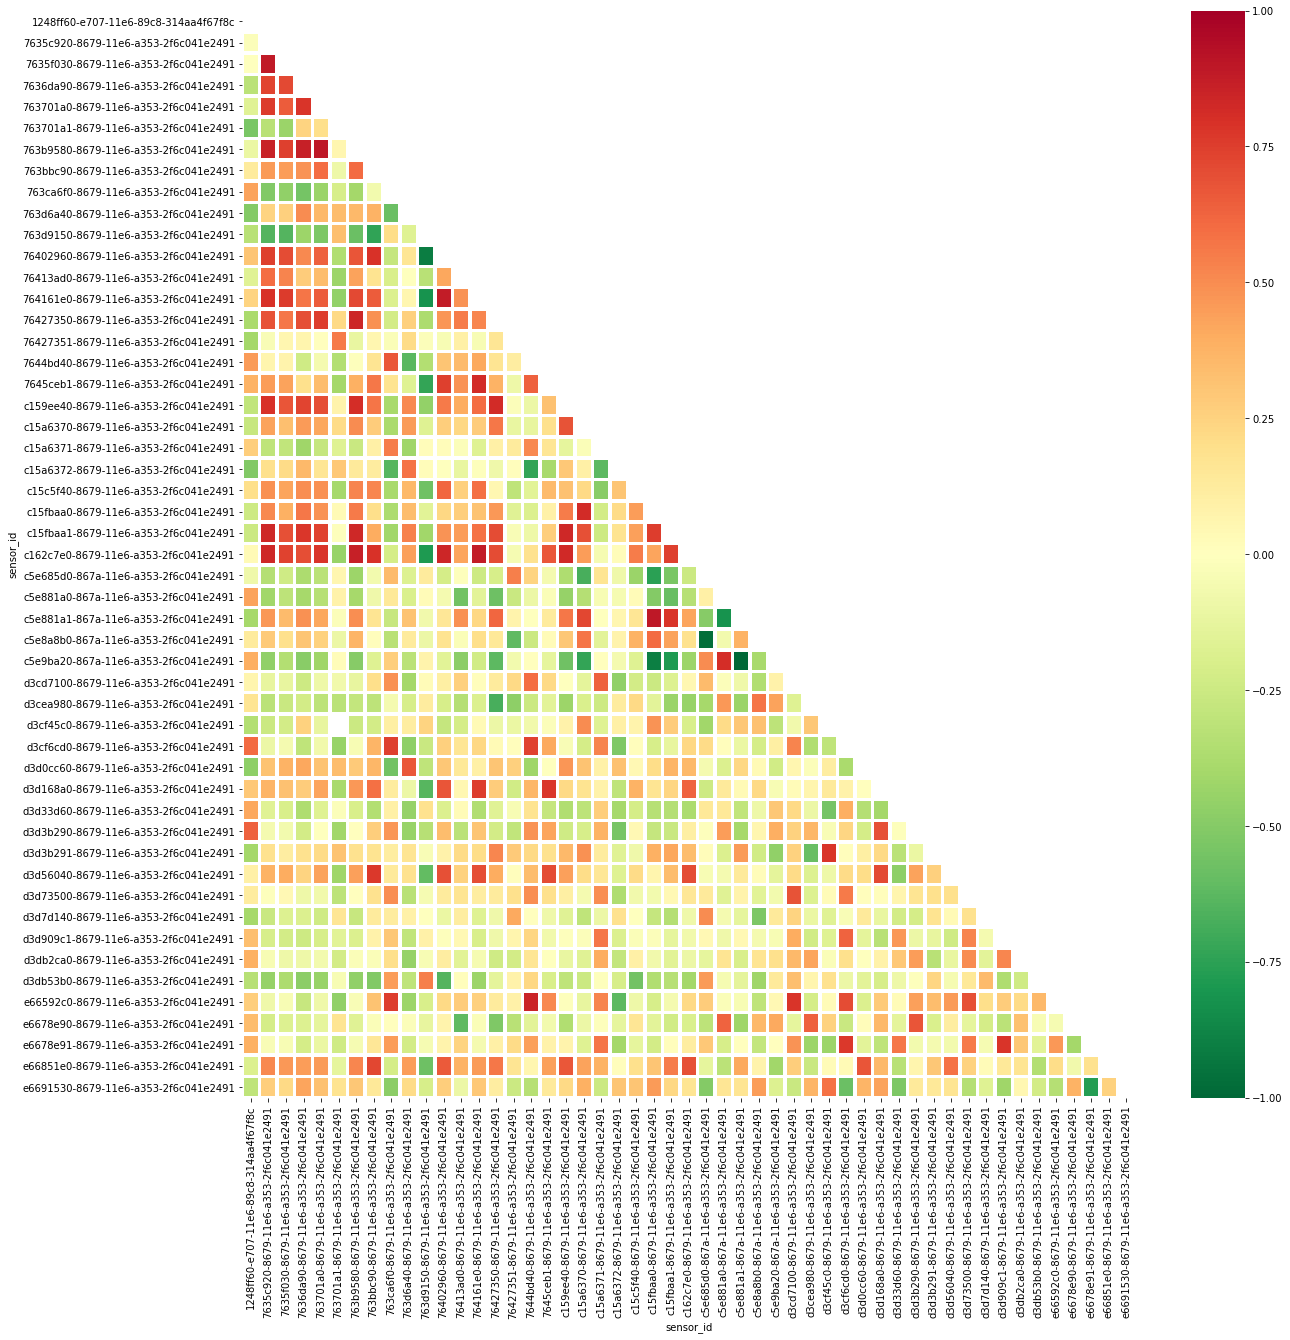

In [644]:
corr_df = df.corr()
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
 # Create the heatmap using seaborn library. 
# # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, ax=ax)
 
# # Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

## Trying to building a Linear Model

In order to do that, we first need to create a data frame with the columns representing only those sensors for ONE NODE.

Try to see if pd.pivot() can help with grouping Nodes together

In [645]:
# nodes.name # so we have 10 "nodes" with 6 sensors each. [T, Pr, HUMA, PPM , PPM2, BATT]

**Task: Merge the full data set with the nodes**

1. Perform the merge above.
2. Resample the data to the daily level and show a sample of the mean.
3. Pivot the table to show columns of the sensor types as columns vs name and timestamp


<img src = "images/example-3.png" width=450 height=400>

In [646]:
#merging two dataframes
fullnode = pd.merge(data, nodes_df, left_on='node_id', right_on='id')
fullnode

timestamp                                  id_x  value  \
0      2016-08-03 04:39:25+00:00  764c5e60-8679-11e6-a353-2f6c041e2491   98.0   
1      2016-08-03 04:47:41+00:00  765251d0-8679-11e6-a353-2f6c041e2491   98.0   
2      2016-08-03 05:08:52+00:00  7655fb50-8679-11e6-a353-2f6c041e2491   98.0   
3      2016-08-03 05:14:08+00:00  7659cbe0-8679-11e6-a353-2f6c041e2491   98.0   
4      2016-08-03 05:28:55+00:00  765dea90-8679-11e6-a353-2f6c041e2491   96.0   
...                          ...                                   ...    ...   
176529 2016-08-31 19:00:01+00:00  39e16940-e707-11e6-89c8-314aa4f67f8c  125.0   
176530 2016-08-31 19:50:00+00:00  39e82000-e707-11e6-89c8-314aa4f67f8c  143.0   
176531 2016-08-31 21:00:02+00:00  39f08470-e707-11e6-89c8-314aa4f67f8c  175.0   
176532 2016-08-31 21:50:00+00:00  39f84ca0-e707-11e6-89c8-314aa4f67f8c  164.0   
176533 2016-08-31 23:00:00+00:00  39fd55b0-e707-11e6-89c8-314aa4f67f8c   89.0   

                                   sensor_id  \
0       7635c920-8679-11e6-a353-2f6c041e2491   
1       7635c920-8679-11e6-a353-2f6c041e2491   
2       7635c920-8679-11e6-a353-2f6c041e2491   
3       7635c920-8679-11e6-a353-2f6c041e2491   
4       7635c920-8679-11e6-a353-2f6c041e2491   
...                                      ...   
176529  1248ff60-e707-11e6-89c8-314aa4f67f8c   
176530  1248ff60-e707-11e6-89c8-314aa4f67f8c   
176531  1248ff60-e707-11e6-89c8-314aa4f67f8c   
176532  1248ff60-e707-11e6-89c8-314aa4f67f8c   
176533  1248ff60-e707-11e6-89c8-314aa4f67f8c   

                                        id_x description_x  data_frequency  \
0       7635c920-8679-11e6-a353-2f6c041e2491            \N         1800000   
1       7635c920-8679-11e6-a353-2f6c041e2491            \N         1800000   
2       7635c920-8679-11e6-a353-2f6c041e2491            \N         1800000   
3       7635c920-8679-11e6-a353-2f6c041e2491            \N         1800000   
4       7635c920-8679-11e6-a353-2f6c041e2491            \N         1800000   
...                                      ...           ...             ...   
176529  1248ff60-e707-11e6-89c8-314aa4f67f8c            \N         1800000   
176530  1248ff60-e707-11e6-89c8-314aa4f67f8c            \N         1800000   
176531  1248ff60-e707-11e6-89c8-314aa4f67f8c            \N         1800000   
176532  1248ff60-e707-11e6-89c8-314aa4f67f8c            \N         1800000   
176533  1248ff60-e707-11e6-89c8-314aa4f67f8c            \N         1800000   

       status_x              created_at_x                     updated_at_x  \
0       OFFLINE 2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
1       OFFLINE 2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
2       OFFLINE 2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
3       OFFLINE 2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
4       OFFLINE 2016-08-03 04:39:25+00:00 2016-09-29 20:13:52.793000+00:00   
...         ...                       ...                              ...   
176529  OFFLINE 2016-07-01 00:00:31+00:00 2017-01-30 16:24:05.832000+00:00   
176530  OFFLINE 2016-07-01 00:00:31+00:00 2017-01-30 16:24:05.832000+00:00   
176531  OFFLINE 2016-07-01 00:00:31+00:00 2017-01-30 16:24:05.832000+00:00   
176532  OFFLINE 2016-07-01 00:00:31+00:00 2017-01-30 16:24:05.832000+00:00   
176533  OFFLINE 2016-07-01 00:00:31+00:00 2017-01-30 16:24:05.832000+00:00   

        ...     si_unit type_id                                  id_y  name  \
0       ...  percentage     BAT  762b8ff0-8679-11e6-a353-2f6c041e2491   N10   
1       ...  percentage     BAT  762b8ff0-8679-11e6-a353-2f6c041e2491   N10   
2       ...  percentage     BAT  762b8ff0-8679-11e6-a353-2f6c041e2491   N10   
3       ...  percentage     BAT  762b8ff0-8679-11e6-a353-2f6c041e2491   N10   
4       ...  percentage     BAT  762b8ff0-8679-11e6-a353-2f6c041e2491   N10   
...     ...         ...     ...                                   ...   ...   
176529  ...      counts    RSAM  ede3ed60-e701

In [647]:
fullnode.shape

(176534, 24)

In [648]:
fullnode.head(2)

timestamp                                  id_x  value  \
0 2016-08-03 04:39:25+00:00  764c5e60-8679-11e6-a353-2f6c041e2491   98.0   
1 2016-08-03 04:47:41+00:00  765251d0-8679-11e6-a353-2f6c041e2491   98.0   

                              sensor_id                                  id_x  \
0  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   
1  7635c920-8679-11e6-a353-2f6c041e2491  7635c920-8679-11e6-a353-2f6c041e2491   

  description_x  data_frequency status_x              created_at_x  \
0            \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   
1            \N         1800000  OFFLINE 2016-08-03 04:39:25+00:00   

                      updated_at_x  ...     si_unit type_id  \
0 2016-09-29 20:13:52.793000+00:00  ...  percentage     BAT   
1 2016-09-29 20:13:52.793000+00:00  ...  percentage     BAT   

                                   id_y name description_y location status_y  \
0  762b8ff0-8679-11e6-a353-2f6c041e2491  N10            \N       \N  OFFLINE   
1  762b8ff0-8679-11e6-a353-2f6c041e2491  N10            \N       \N  OFFLINE   

               created_at_y                     updated_at_y  \
0 2016-08-03 04:39:25+00:00 2016-09-29 19:20:17.431000+00:00   
1 2016-08-03 04:39:25+00:00 2016-09-29 19:20:17.431000+00:00   

                             volcano_id  
0  35dc3e90-8679-11e6-bda3-ef77801087ee  
1  35dc3e90-8679-11e6-bda3-ef77801087ee  

[2 rows x 24 columns]

In [649]:
fullnode.set_index('timestamp', inplace=True)

In [650]:
fullnode.resample('D').mean()

value  data_frequency
timestamp                                            
2016-07-01 00:00:00+00:00  306.902098       1800000.0
2016-07-02 00:00:00+00:00  267.804196       1800000.0
2016-07-03 00:00:00+00:00  286.972028       1800000.0
2016-07-04 00:00:00+00:00  339.860140       1800000.0
2016-07-05 00:00:00+00:00  445.828571       1800000.0
...                               ...             ...
2016-10-02 00:00:00+00:00   84.783231       1800000.0
2016-10-03 00:00:00+00:00   79.059548       1800000.0
2016-10-04 00:00:00+00:00   77.155172       1800000.0
2016-10-05 00:00:00+00:00   73.356674       1800000.0
2016-10-06 00:00:00+00:00   68.235294       1800000.0

[98 rows x 2 columns]

In [651]:
# fullnode.pivot_table(index=['timestamp', 'name'], columns='type', values='value')
fn_wide = fullnode.pivot_table(index=['timestamp','name'], columns=['type'], values='value')

In [652]:
#Now, let's make the Node ('name') into its own column. We do this by reset_index() for that level (=1)
fn_wide.reset_index(level=1, inplace=True)

In [653]:
fn_wide.head(2)

type                       name   RSAM  battery  carbon dioxide concentration  \
timestamp                                                                       
2016-07-01 00:00:31+00:00  RSAM  455.0      NaN                           NaN   
2016-07-01 00:10:02+00:00  RSAM  213.0      NaN                           NaN   

type                       humidity  hydrogen sulfide concentration  pressure  \
timestamp                                                                       
2016-07-01 00:00:31+00:00       NaN                             NaN       NaN   
2016-07-01 00:10:02+00:00       NaN                             NaN       NaN   

type                       temperature  
timestamp                               
2016-07-01 00:00:31+00:00          NaN  
2016-07-01 00:10:02+00:00          NaN

Before we can perform Linear Regression, we have one last step remaining. We'd like to "resample" all the data, aggregating it down to 'Daily' Levels.

In [654]:
lmfn = fn_wide.resample('D').mean()

In [655]:
#checking for missing values
missing_values_table(lmfn) #calling the function

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
type                                                             
carbon dioxide concentration                69               70.4
humidity                                    68               69.4
hydrogen sulfide concentration              68               69.4
pressure                                    68               69.4
temperature                                 68               69.4
battery                                     56               57.1
RSAM                                        36               36.7

**Observation:** The percentage of missing value in all columns in this dataframe is very significant. Deleting the NaN values will definetely affect the credibility of the dataframe.
    
Hence we will explore other options such as resampling down to hourly levels

In [656]:
#
lmfn2 = fn_wide.resample('H').mean()

In [657]:
missing_values_table(lmfn2) #calling the function

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
type                                                             
carbon dioxide concentration              1742               74.6
hydrogen sulfide concentration            1737               74.4
humidity                                  1736               74.3
pressure                                  1736               74.3
temperature                               1736               74.3
battery                                   1503               64.3
RSAM                                       850               36.4

**Observation**: Percentage of NaN values does not decrease. Thus, we are going to work with hourly average

### End of Stitching. 

**The Digital Thread for this dataset has been created**

This "digital Thread" has been used to 'stitch' the data frame with all the values we wish to analyze.

---
Now we finally have the data frame in the shape we wanted to enable Linear Regression.

### 8.0 Sample Modeling

**8.1 Building A Battery Remaining-Life prediction model **
Build a machine learning model (LR, tree-based or any other) to try and predict the Battery life (remaining) as a function of any of the other sensor characteristic.

* Which variable (sensor) is a good predictor of battery life?
* Is your linear regression a "good fit?"
* What it the RMSE of your predicted values?

**Carrying out dataframe exploration**

In [658]:
lmfn.describe()

type         RSAM    battery  carbon dioxide concentration   humidity  \
count   62.000000  42.000000                     29.000000  30.000000   
mean   261.939330  75.430055                    346.823410  58.820877   
std    100.862440  20.952203                    245.431962  19.626852   
min     86.496503  38.742520                      1.165304  28.960396   
25%    183.818182  55.750785                    150.738548  39.876103   
50%    264.232485  78.115251                    335.450750  61.747112   
75%    337.113636  96.024306                    516.037000  76.540694   
max    494.041958  97.419608                    935.874162  87.126642   

type   hydrogen sulfide concentration      pressure  temperature  
count                       30.000000  3.000000e+01    30.000000  
mean                        29.616125  1.255737e+06   -48.848781  
std                        148.254949  1.563750e+06    74.441163  
min                          0.189331  9.199418e+04  -144.177671  
25%                          0.336605  9.759493e+04  -143.175446  
50%                          0.931684  1.064047e+05   -20.736104  
75%                          2.235000  2.481076e+06    18.640262  
max                        813.951000  5.164205e+06    43.191333

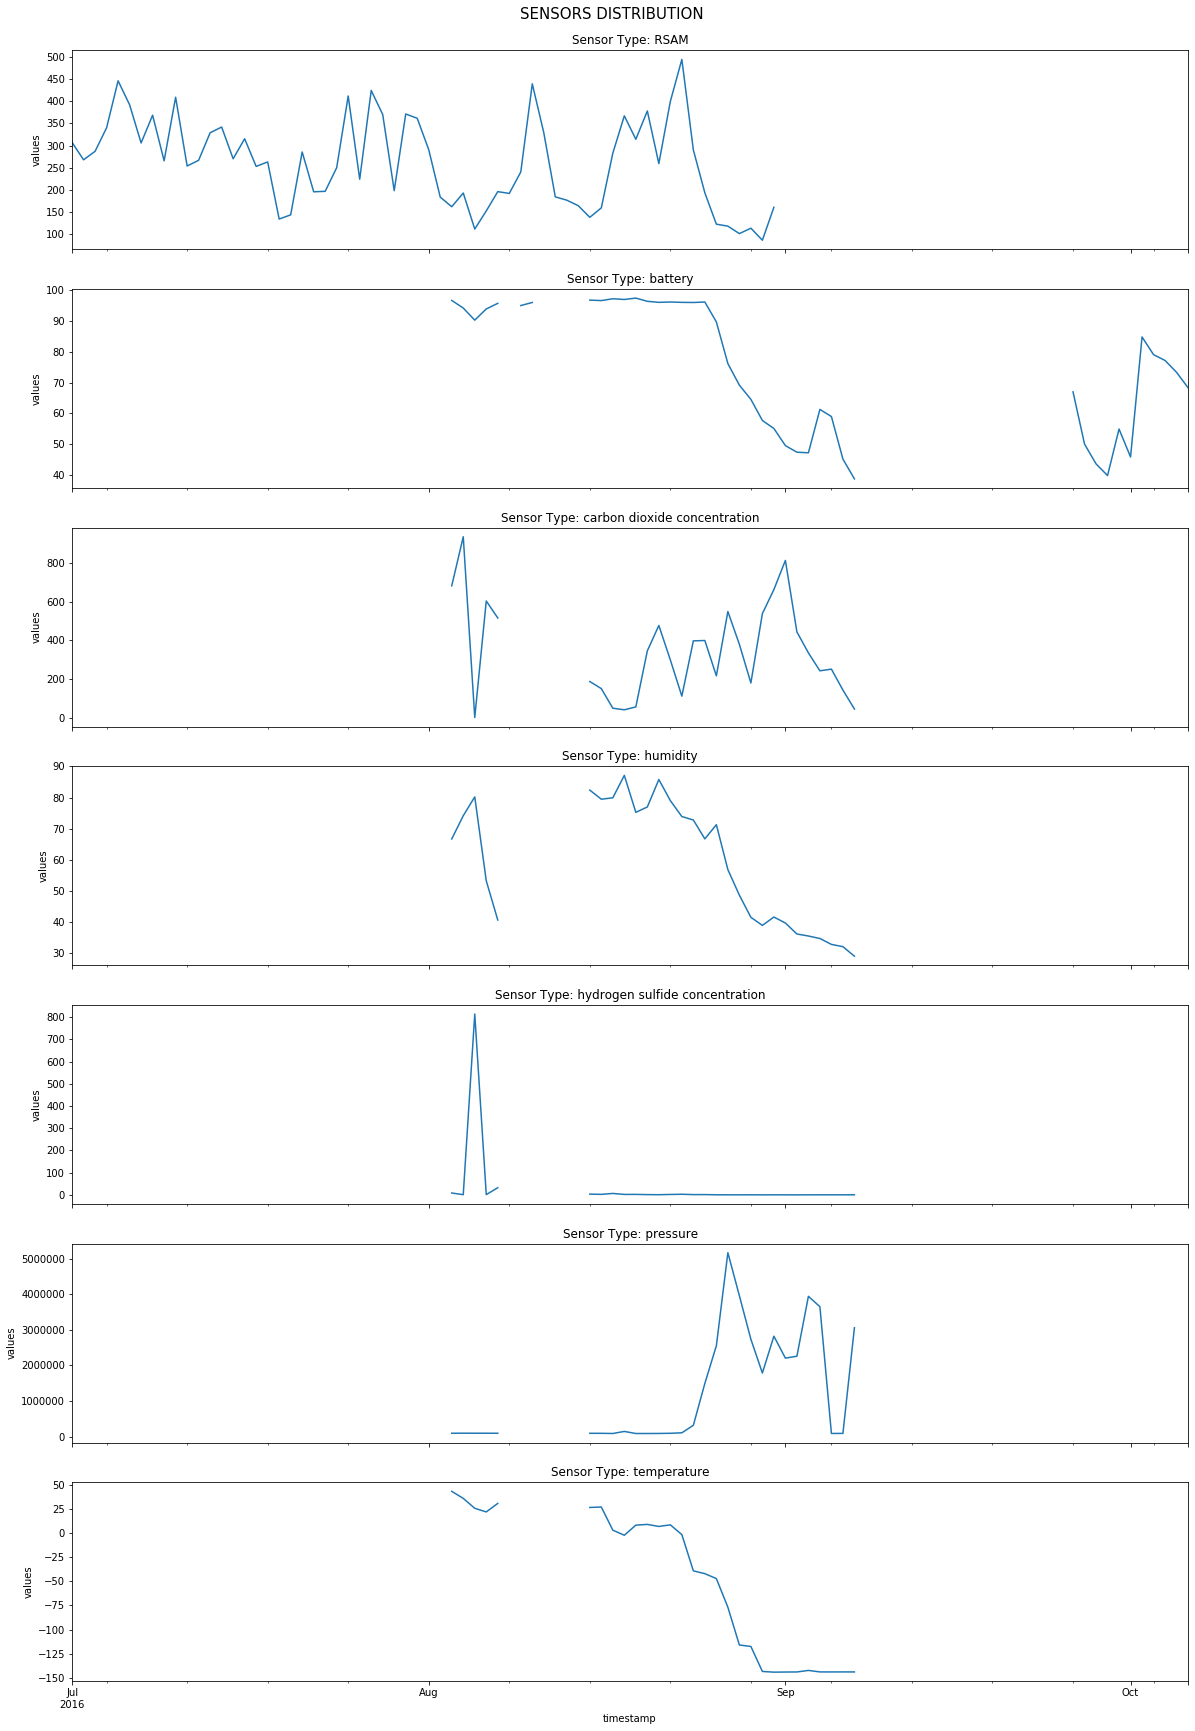

In [659]:

#plottinng dataframe distribution

list=lmfn.columns.to_list()
fig, axs = plt.subplots(7, sharex=True)
fig.set_size_inches(20,30)

for s in (lmfn.columns):
    #plt.figure(figsize=(20, 20))
    i=list.index(str(s))
    lmfn[str(s)].plot(ax=axs[i])
    axs[i].set_title('Sensor Type: ' + str(s))
    axs[i].set_ylabel('values')
    
##### temp=data[data.type_id =='TCA']



    
fig.suptitle('SENSORS DISTRIBUTION', size=15, y=0.9);
    

**Observation:** There is too much irregularity and inconsistency in the data frame distribution. And it does not contain enough data to carry out a accurate analysis
    
Hence i will carry out interpolation to fill the NaN values. Also the temperature has negative values. This is a volcanic site and thus hot temperatures are expected not cold ones. So we will assume there was an error in data collection and remove the negative signs from the temperature column

In [660]:
lmfn.temperature=abs(lmfn.temperature)

In [661]:
lmfn.describe()

type         RSAM    battery  carbon dioxide concentration   humidity  \
count   62.000000  42.000000                     29.000000  30.000000   
mean   261.939330  75.430055                    346.823410  58.820877   
std    100.862440  20.952203                    245.431962  19.626852   
min     86.496503  38.742520                      1.165304  28.960396   
25%    183.818182  55.750785                    150.738548  39.876103   
50%    264.232485  78.115251                    335.450750  61.747112   
75%    337.113636  96.024306                    516.037000  76.540694   
max    494.041958  97.419608                    935.874162  87.126642   

type   hydrogen sulfide concentration      pressure  temperature  
count                       30.000000  3.000000e+01    30.000000  
mean                        29.616125  1.255737e+06    66.928647  
std                        148.254949  1.563750e+06    58.103921  
min                          0.189331  9.199418e+04     1.616157  
25%                          0.336605  9.759493e+04    22.638333  
50%                          0.931684  1.064047e+05    40.651653  
75%                          2.235000  2.481076e+06   143.175446  
max                        813.951000  5.164205e+06   144.177671

Text(0, 0.5, 'degrees')

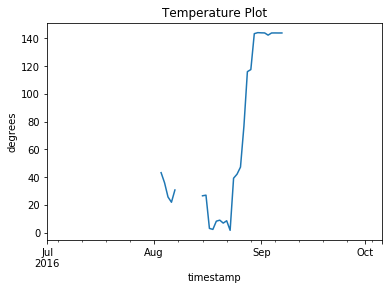

In [662]:
lmfn.temperature.plot()
plt.title('Temperature Plot')
plt.ylabel('degrees')

Observation: The changes have been implemented. There are no negative values.

Now we carry out interpolation

In [663]:
new = lmfn.dropna(axis=1, how='all').interpolate(limit=20, limit_direction='both') #interpolate

In [664]:
missing_values_table(new) #calling the function to check for missing values

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
type                                                             
carbon dioxide concentration                22               22.4
humidity                                    22               22.4
hydrogen sulfide concentration              22               22.4
pressure                                    22               22.4
temperature                                 22               22.4
RSAM                                        16               16.3
battery                                     13               13.3

There are still missing values. we fill them with zero. Rather than dropping the rows, this is to prevent the loss of other significant rows due to NaN value in a column corresponding to that row

In [665]:
df=new.fillna(0)

Lets see how our new plot looks like

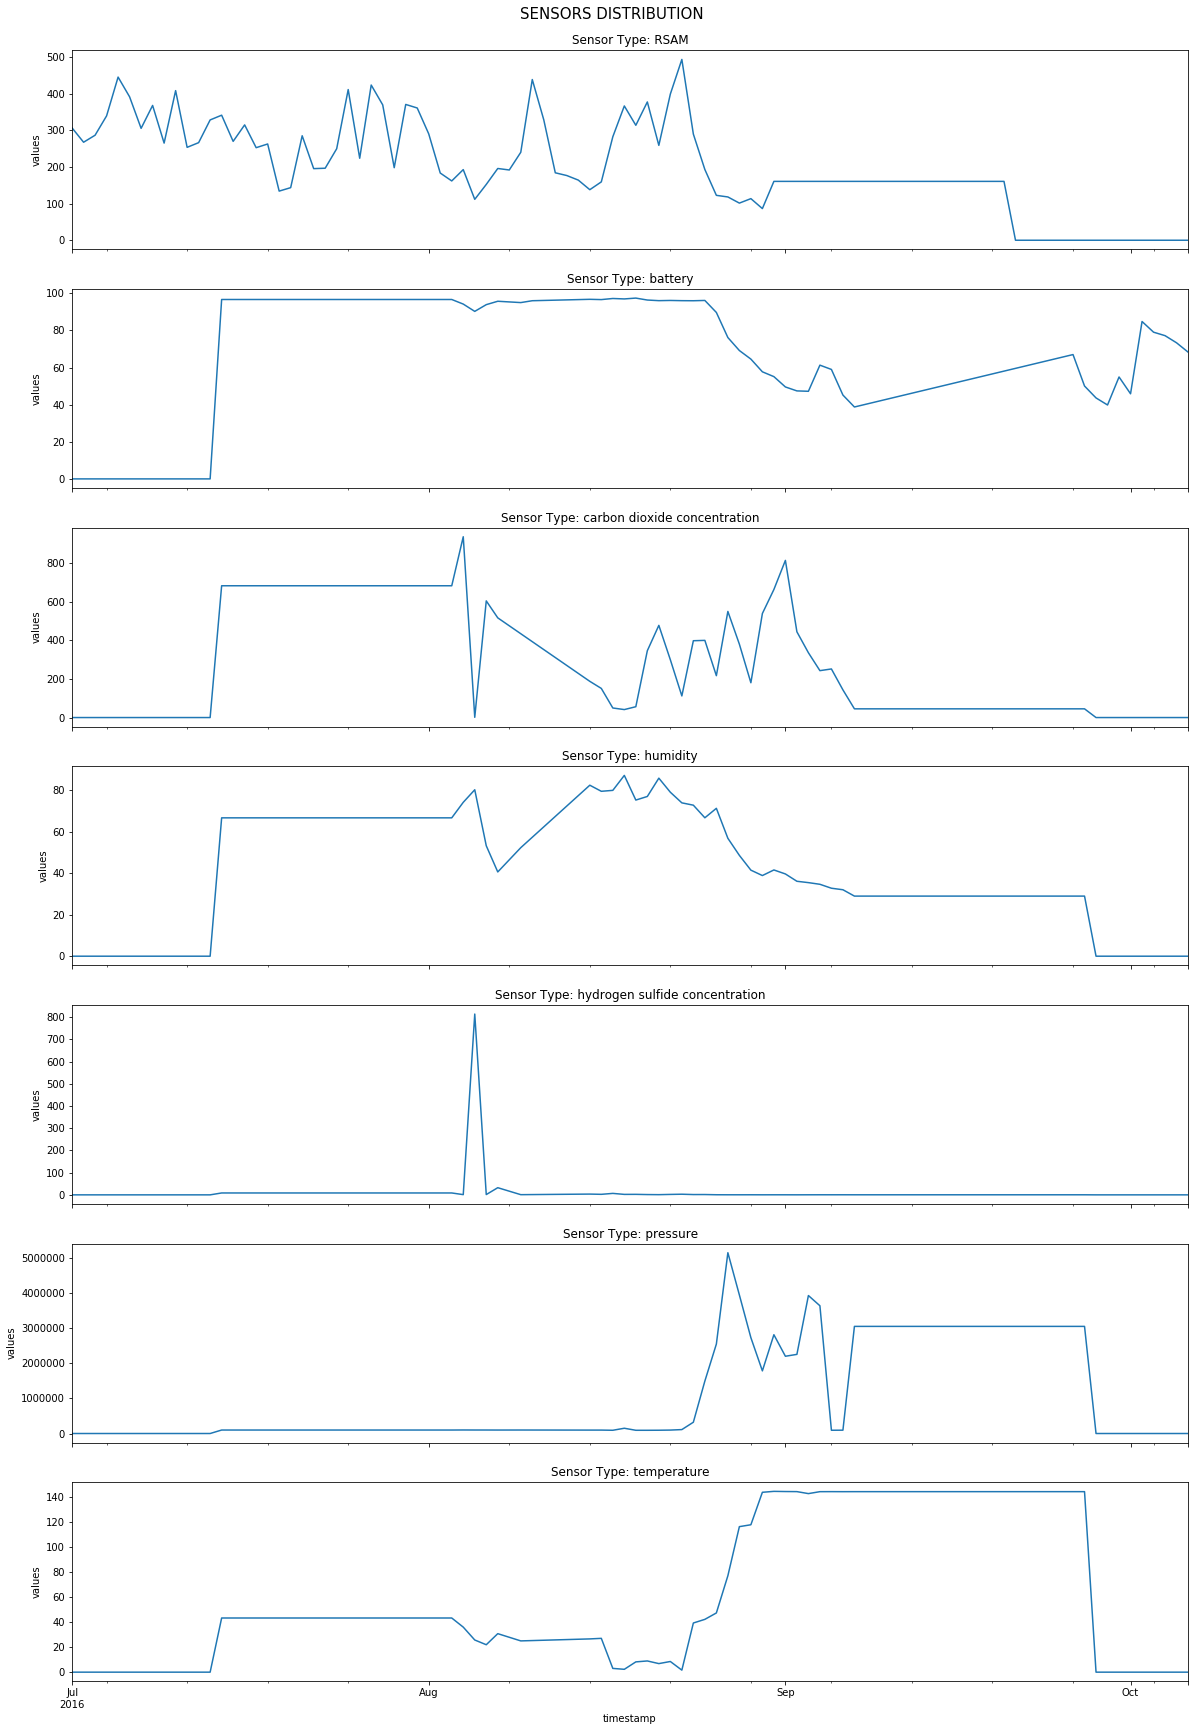

In [666]:
#plottinng dataframe distribution

list=df.columns.to_list()
fig, axs = plt.subplots(7, sharex=True)
fig.set_size_inches(20,30)

for s in (df.columns):
    #plt.figure(figsize=(20, 20))
    i=list.index(str(s))
    df[str(s)].plot(ax=axs[i])
    axs[i].set_title('Sensor Type: ' + str(s))
    axs[i].set_ylabel('values')
    
##### temp=data[data.type_id =='TCA']



    
fig.suptitle('SENSORS DISTRIBUTION', size=15, y=0.9);
    
    

In [667]:
df.describe()

type         RSAM    battery  carbon dioxide concentration   humidity  \
count   98.000000  98.000000                     98.000000  98.000000   
mean   198.541037  66.672036                    276.170840  41.433701   
std    125.545891  33.034871                    286.484756  28.265457   
min      0.000000   0.000000                      0.000000   0.000000   
25%    145.889860  47.473816                     45.078879  28.960396   
50%    163.171329  71.243498                    146.979244  39.250168   
75%    286.604895  96.653141                    590.177605  66.673333   
max    494.041958  97.419608                    935.874162  87.126642   

type   hydrogen sulfide concentration      pressure  temperature  
count                       98.000000  9.800000e+01    98.000000  
mean                        11.139346  1.035116e+06    60.276091  
std                         82.067475  1.438440e+06    58.507460  
min                          0.000000  0.000000e+00     0.000000  
25%                          0.274928  9.257563e+04     3.949953  
50%                          0.324291  9.919557e+04    43.191333  
75%                          5.773990  3.000125e+06   143.943280  
max                        813.951000  5.164205e+06   144.177671

Checking the correlation 

In [668]:
#correlation analysis
corr_df = df.corr()

In [669]:
# # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# # top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

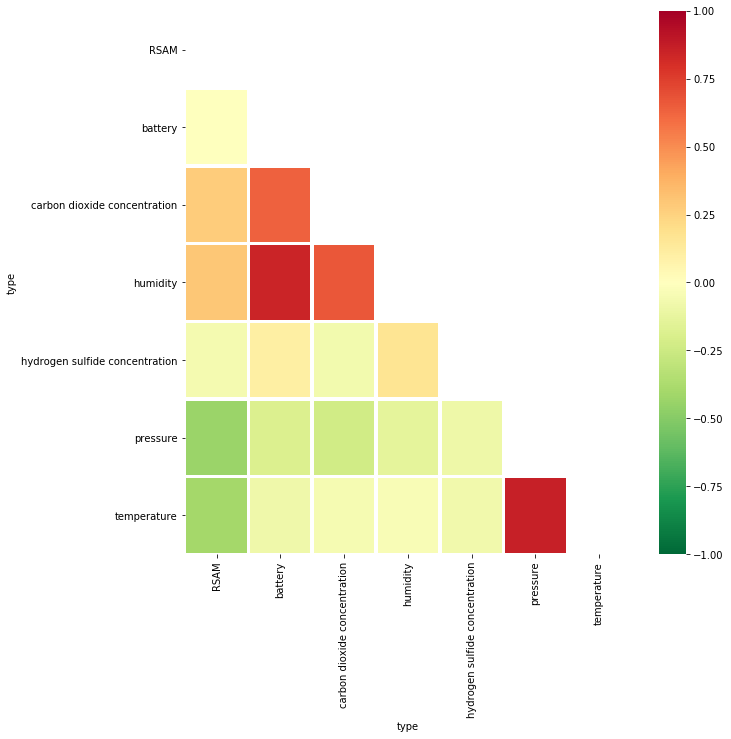

In [670]:
# # Create the heatmap using seaborn library. 
# # List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, ax=ax)
 
# # Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [671]:
df.shape

(98, 7)

Carrying out Linear regression using RandomForestRegressor

In [672]:
X=df.drop(['battery'],axis=1).values
y=df.battery.values

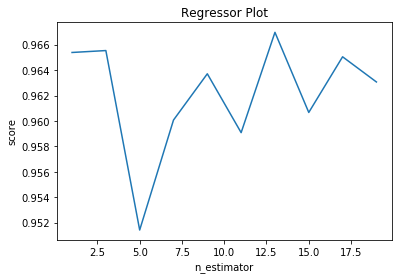

In [673]:
model = RandomForestRegressor(n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#Plotting elbow curve to find the optimal number of n_estimators
estimators = np.arange(1, 20, 2)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Regressor Plot")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [674]:
model.set_params(n_estimators=9)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=9, n_jobs=-1)

In [675]:
labels=df.drop(['battery'],axis=1).columns

In [676]:
#feature selection
result = pd.DataFrame()
result['feature'] = labels
result['importance'] = model.feature_importances_
result.sort_values(by=['importance'], ascending=False, inplace=True)
result

feature  importance
2                        humidity    0.352461
0                            RSAM    0.335573
3  hydrogen sulfide concentration    0.295218
5                     temperature    0.009169
4                        pressure    0.006710
1    carbon dioxide concentration    0.000868

**Observation 1:** Based on the correlation heat map and feature importance, Humidity is a good predictor of battery life

In [677]:
print('Accuracy score: {}'.format(model.score(X_test, y_test)))


Accuracy score: 0.9617179847509998


In [678]:
#Crossvalidating
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=folds)
scores 

array([0.93479653, 0.99411598, 0.82192894, 0.99055331, 0.87985806,
       0.4123447 , 0.94247998, 0.99981632, 0.93763752, 0.9039429 ])

**Observation 2:** Based on my accuracy score and cross validation, I can say that my regression model is a good fit

In [679]:
y_pred=model.predict(X_test)

Now we compute the RMSE score

In [680]:
#Computing the RMSE
print('RMSE score: {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))

RMSE score: 6.856056673792178


**Observation 3:** My RMSE score based on the predicted values is shown above

Based on feature importance we drop carbon dioxide concentration and pressure to see if the RMSE will improve


In [681]:
X=df.drop(['battery','carbon dioxide concentration','pressure'],axis=1).values
y=df.battery.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model.set_params(n_estimators=9)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

print('RMSE score: {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
                     


RMSE score: 6.085864082986505


**Observation 4:** We can see that removing columns based on feature importance improved the RMSE value